# Semantic Similarity Search for Professional Roles

This notebook focuses on the creation and evaluation of a Semantic Search Index designed to map free-text user inputs to the canonical roles established in our career transition graph. By utilizing Sentence Transformers for high-dimensional vector encoding and FAISS for efficient indexing, the system can resolve synonyms, typos, and industry slang into precise graph nodes. The core objective is to ensure that regardless of how a user describes their current or target role, the application can accurately locate the corresponding node to initiate pathfinding. The notebook covers the full pipeline: from generating role embeddings and building a binary vector index to performing hybrid retrieval and benchmarking performance across multiple transformer architectures using metrics like Top-K Accuracy and MRR.

# Graph Loading & Model Initialization

In [2]:
import pickle

# Load the previously saved Career Graph to access the list of unique job titles
with open('wannabe_graph.pkl', 'rb') as f:
    G = pickle.load(f)

print(f"Graph loaded: {G.number_of_nodes()} nodes.")

Graph loaded: 171 nodes.


# Offline: Building the Embedding Index

In [5]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import os

# Suppress warnings and load the all-MiniLM-L6-v2 model for efficient vector encoding
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

# Load the model (we evaluate and specify why we choose this later in the notebook)

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
print("Model 'all-MiniLM-L6-v2' loaded successfully!")


Model 'all-MiniLM-L6-v2' loaded successfully!


In [6]:
# Extract all unique canonical roles directly from the graph nodes
canonical_roles = list(G.nodes())

# Generate high-dimensional vector embeddings for every role
role_embeddings = model.encode(canonical_roles)

# Normalize vectors to unit length so that Inner Product search equals Cosine Similarity
role_embeddings = role_embeddings / np.linalg.norm(role_embeddings, axis=1, keepdims=True)
index = faiss.IndexFlatIP(role_embeddings.shape[1])
index.add(role_embeddings.astype('float32'))

In [7]:
# Save the artifacts to binary files for use in the online application
faiss.write_index(index, "wannabe_index.bin")

with open("canonical_roles.pkl", "wb") as f:
    pickle.dump(canonical_roles, f)

print("Offline artifacts saved: wannabe_index.bin and canonical_roles.pkl")

Offline artifacts saved: wannabe_index.bin and canonical_roles.pkl


# Online Retrieval Logic: Hybrid Role Resolution

In [9]:
import faiss
import pickle

# Load the FAISS index
index = faiss.read_index("wannabe_index.bin")

# Load the canonical_roles list
with open("canonical_roles.pkl", "rb") as f:
    canonical_roles = pickle.load(f)

print(f"Online system ready with {len(canonical_roles)} searchable roles.")

Online system ready with 171 searchable roles.


In [10]:
def resolve_role_input(input_text, k=3):
    """
    Resolves a raw string input into the most similar canonical roles in the database.
    """
    
    query = input_text.lower().strip()
    
    # Fast path: If the input is exactly as stored in our graph, return immediately
    if query in canonical_roles:
        return [(query, 1.0)] 
    
    # Semantic path: Encode the input and search the FAISS vector space
    query_embedding = model.encode([query])
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)
    
    # Retrieve the top K nearest neighbors (roles with the highest cosine similarity)
    similarities, indices = index.search(query_embedding.astype('float32'), k)

    # Map the resulting IDs back to their human-readable role titles
    results = []
    for score, idx in zip(similarities[0], indices[0]):
        role_name = canonical_roles[idx]
        results.append((role_name, float(score)))
        
    return results

In [11]:
# Example Usage
input_text = "manufactring engineer"
top_candidates = resolve_role_input(input_text, k=3)

print(f"Top results for '{input_text}':")
for role, score in top_candidates:
    print(f" -> {role} (Similarity: {score:.4f})")

Top results for 'manufactring engineer':
 -> manufacturing engineer (Similarity: 0.7778)
 -> industrial engineer (Similarity: 0.7686)
 -> production engineer (Similarity: 0.7525)


# Models Evaluation & Selection

In [13]:
evaluation_test_set = {
    # --- Group 1: Typos & Misspellings (The "Robustness" Test) ---
    "softare testr": "software tester", "prograrmer": "software developer", 
    "sql devloper": "database developer", "appication engineer": "application engineer",
    "softare manager": "software manager", "data quallity spec": "data quality specialist",
    "logistics enginr": "logistics engineer", "busines developer": "business developer",
    "mobil app dev": "mobile application developer", "datbase designer": "database designer",
    "civil engner": "civil engineer", "softare architct": "software architect",
    "telecom enginer": "telecommunications engineer", "comp hardware eng": "computer hardware engineer",
    "electromec engineer": "electromechanical engineer", "transport enginr": "transport engineer",

    # --- Group 2: Synonyms & Industry Slang (The "Semantic" Test) ---
    "coder": "software developer", "quality assurance": "software tester",
    "it head": "software manager", "systems designer": "software architect",
    "landscape artist": "landscape architect", "sales engineer": "business developer",
    "db architect": "database designer", "data center tech": "data centre operator",
    "hardware dev": "computer hardware engineer", "network engineer": "telecommunications engineer",
    "construction lead": "construction engineer", "lighting designer": "intelligent lighting engineer",
    "backend dev": "software developer", "frontend engineer": "software developer",
    "data integrity officer": "data quality specialist", "deployment engineer": "commissioning engineer",

    # --- Group 3: Abbreviations & Acronyms ---
    "sw developer": "software developer", "sw tester": "software tester",
    "hw engineer": "computer hardware engineer", "ict architect": "ict system architect",
    "qa engineer": "software tester", "db developer": "database developer",
    "it manager": "software manager", "app eng": "application engineer",
    "comm engineer": "commissioning engineer", "elec-mech engineer": "electromechanical engineer",

    # --- Group 4: Broad vs. Specific Roles ---
    "java developer": "software developer", "python programmer": "software developer",
    "ios creator": "mobile application developer", "android dev": "mobile application developer",
    "game seller": "computer games, multimedia and software specialised seller",
    "software distribution lead": "computers, computer peripheral equipment and software distribution manager",
    "pc hardware specialist": "computer hardware engineer", "building engineer": "civil engineer",
    "site commissioning": "commissioning engineer", "road engineer": "transport engineer",

    # --- Group 5: Complex/Long Phrases ---
    "specialist in data quality": "data quality specialist",
    "expert in database design": "database designer",
    "manager for software teams": "software manager",
    "engineer for telecommunications": "telecommunications engineer",
    "architect for software systems": "software architect",
    "computer games and software sales": "computer games, multimedia and software specialised seller",
    "multimedia software retailer": "computer games, multimedia and software specialised seller",
    "logistic system designer": "logistics engineer",

    "scripting expert": "software developer", "validation engineer": "software tester",
    "tech lead": "software manager", "logic engineer": "calculation engineer",
    "structural engineer": "civil engineer", "infrastructure architect": "ict system architect",
    "mastering expert": "sound mastering engineer", "audio mastering": "sound mastering engineer",
    "database admin": "database developer", "db admin": "database developer",
    "logistics lead": "logistics engineer", "supply chain engineer": "logistics engineer",
    "enterprise architect": "ict system architect", "software builder": "software developer",
    "app designer": "mobile application developer", "mobile dev": "mobile application developer",
    "distribution head": "computers, computer peripheral equipment and software distribution manager",
    "wholesale computer manager": "computers, computer peripheral equipment and software distribution manager",
    "it compliance": "compliance engineer", "regulatory engineer": "compliance engineer",
    "urban architect": "landscape architect", "environmental designer": "landscape architect",
    "smart lighting specialist": "intelligent lighting engineer", "lighting system pro": "intelligent lighting engineer",
    "database lead": "database designer", "data storage designer": "database designer",
    "network architect": "telecommunications engineer", "comm tech": "telecommunications engineer",
    "hardware system engineer": "computer hardware engineer", "circuit engineer": "computer hardware engineer",
    "mechanical-electrical eng": "electromechanical engineer", "robotic systems engineer": "electromechanical engineer",
    "project commissioning": "commissioning engineer", "startup engineer": "commissioning engineer",
    "transportation specialist": "transport engineer", "traffic engineer": "transport engineer",
    "building construction": "construction engineer", "on-site engineer": "construction engineer",
    "data audit specialist": "data quality specialist", "clean data expert": "data quality specialist",
    "software product lead": "software manager", "engineering manager": "software manager",
    "system logic analyst": "calculation engineer", "mathematical engineer": "calculation engineer",
    "business growth lead": "business developer", "market expansion engineer": "business developer"
}

In [14]:
import numpy as np
import pandas as pd

# Define the calculation for core Information Retrieval (IR) metrics
def calculate_metrics(test_set, k=3):
    """
    Evaluates the semantic search logic against a ground-truth test set.
    Metrics: Top-1 Accuracy, Top-K Accuracy, MRR, and nDCG.
    """
    top_1_hits = 0
    top_k_hits = 0
    total_mrr = 0
    total_ndcg = 0
    
    results_log = []

    for query, truth in test_set.items():
        # Use existing FAISS search function
        predictions = resolve_role_input(query, k=k)
        rankings = [p[0] for p in predictions]
        
        # Top-1 & Top-K Accuracy
        hit_top_1 = 1 if rankings[0] == truth else 0
        hit_top_k = 1 if truth in rankings else 0
        
        top_1_hits += hit_top_1
        top_k_hits += hit_top_k
        
        # MRR Calculation
        mrr_score = 0
        if truth in rankings:
            rank = rankings.index(truth) + 1
            mrr_score = 1.0 / rank
        total_mrr += mrr_score
        
        # nDCG Calculation (Binary Relevance) 
        ndcg_score = 0
        if truth in rankings:
            rank = rankings.index(truth) + 1
            dcg = 1.0 / np.log2(rank + 1)
            idcg = 1.0 / np.log2(1 + 1) # Ideal is always at rank 1
            ndcg_score = dcg / idcg
        total_ndcg += ndcg_score

        # Log details for analysis
        results_log.append({
            "Query": query,
            "Truth": truth,
            "Top-1 Prediction": rankings[0],
            "In Top-K": "Yes" if hit_top_k else "No",
            "MRR": round(mrr_score, 3)
        })

    num_queries = len(test_set)
    
    # Summary Statistics
    stats = {
        "Top-1 Accuracy": round(top_1_hits / num_queries, 4),
        f"Top-{k} Accuracy": round(top_k_hits / num_queries, 4),
        "Mean Reciprocal Rank (MRR)": round(total_mrr / num_queries, 4),
        f"nDCG@{k}": round(total_ndcg / num_queries, 4)
    }
    
    return stats, pd.DataFrame(results_log)

# Run the Evaluation
print("Starting Semantic Search Evaluation...")
metrics, detail_df = calculate_metrics(evaluation_test_set, k=3)

# Display Results
print("\n" + "="*30)
print("FINAL EVALUATION METRICS")
print("="*30)
for metric, value in metrics.items():
    print(f"{metric:25}: {value}")
print("="*30)

print("\nDetailed Query Analysis:")
display(detail_df) 

Starting Semantic Search Evaluation...

FINAL EVALUATION METRICS
Top-1 Accuracy           : 0.5755
Top-3 Accuracy           : 0.7075
Mean Reciprocal Rank (MRR): 0.6321
nDCG@3                   : 0.6514

Detailed Query Analysis:


,Query,Truth,Top-1 Prediction,In Top-K,MRR
0,softare testr,software tester,software tester,Yes,1.0
1,prograrmer,software developer,product manager,No,0.0
2,sql devloper,database developer,database developer,Yes,1.0
3,appication engineer,application engineer,application engineer,Yes,1.0
4,softare manager,software manager,software manager,Yes,1.0
...,...,...,...,...,...
101,engineering manager,software manager,industrial engineer,No,0.0
102,system logic analyst,calculation engineer,software analyst,No,0.0
103,mathematical engineer,calculation engineer,calculation engineer,Yes,1.0
104,business growth lead,business developer,business developer,Yes,1.0


### Semantic Search Model Benchmarking & Selection

This section of the notebook is dedicated to the comparative evaluation of multiple Transformer architectures to determine the optimal balance between retrieval accuracy and computational latency. By benchmarking various sentence-transformers models against our ground-truth test set, we can empirically select the most robust engine for mapping user inputs to the career graph. The evaluation focuses on key information retrieval metrics, including Accuracy@1 (exact first-match), Accuracy@K (correct role within the top results), and Mean Reciprocal Rank (MRR), which rewards models for placing the correct role higher in the results list.

Benchmarking: sentence-transformers/paraphrase-MiniLM-L3-v2...
Benchmarking: sentence-transformers/all-MiniLM-L6-v2...
Benchmarking: sentence-transformers/all-mpnet-base-v2...
Benchmarking: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2...
Benchmarking: sentence-transformers/all-distilroberta-v1...


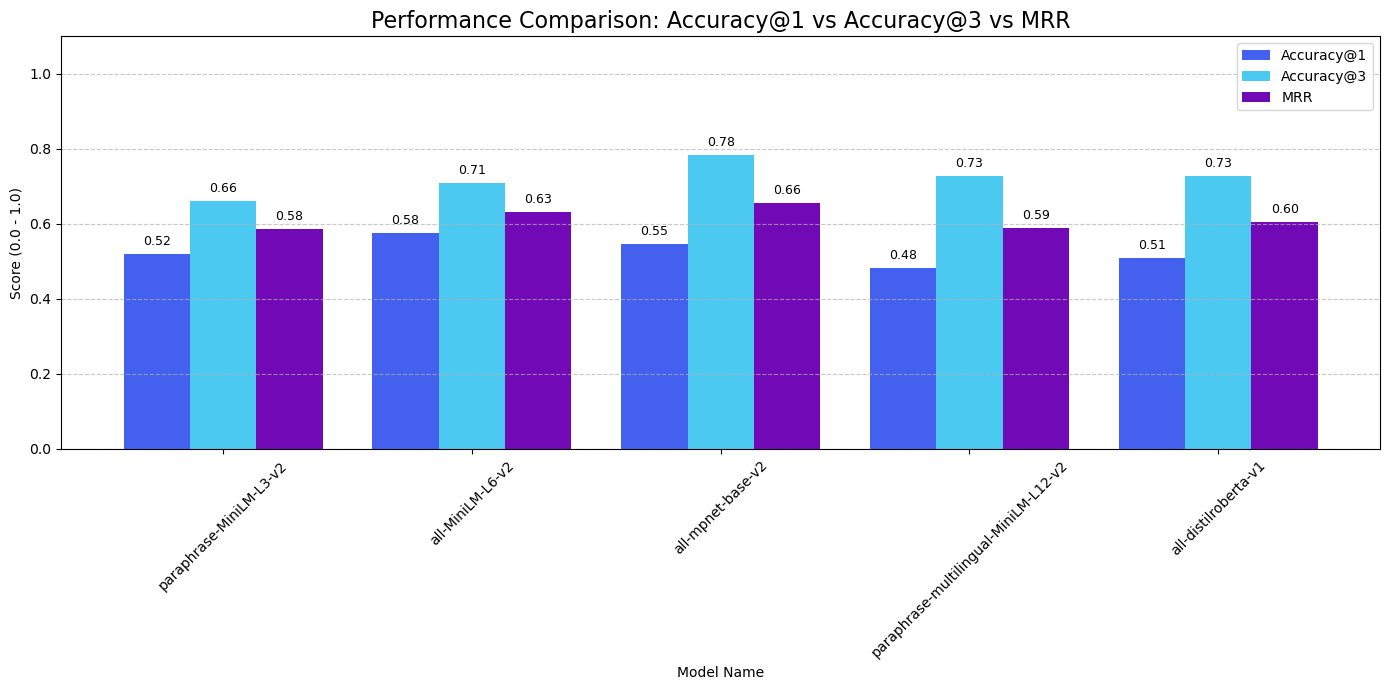

,Accuracy@1,Accuracy@3,MRR,Total Time (s)
all-mpnet-base-v2,0.5472,0.7830,0.6557,12.74
all-MiniLM-L6-v2,0.5755,0.7075,0.6321,4.21
all-distilroberta-v1,0.5094,0.7264,0.6038,8.55
paraphrase-multilingual-MiniLM-L12-v2,0.4811,0.7264,0.5896,9.09
paraphrase-MiniLM-L3-v2,0.5189,0.6604,0.5849,5.35


In [15]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

def evaluate_model(model_name, canonical_roles, test_set, k=3):
    """
    Performs a full retrieval test for a specific transformer model.
    Returns Accuracy, MRR, and processing time.
    """
    
    print(f"Benchmarking: {model_name}...")
    start_time = time.time()
    
    # Initialize the specific model and generate embeddings for all roles in the graph
    model = SentenceTransformer(model_name)    
    role_embeddings = model.encode(canonical_roles, show_progress_bar=False)
    
    # Normalize for Cosine Similarity and add to a fresh FAISS index
    role_embeddings = role_embeddings / np.linalg.norm(role_embeddings, axis=1, keepdims=True)
    d = role_embeddings.shape[1]
    idx = faiss.IndexFlatIP(d)
    idx.add(role_embeddings.astype('float32'))
    
    # Metrics Calculation
    top_1_hits = 0
    top_k_hits = 0  # Counter for Accuracy@K
    total_mrr = 0

    # Iterate through the 100+ query test set (typos, slang, abbreviations)
    for query, truth in test_set.items():
        q_emb = model.encode([query], show_progress_bar=False)
        q_emb = q_emb / np.linalg.norm(q_emb, axis=1, keepdims=True)
        _, indices = idx.search(q_emb.astype('float32'), k)
        
        preds = [canonical_roles[i] for i in indices[0]]
        
        # # Calculate performance metrics
        if preds[0] == truth:
            top_1_hits += 1
            
        if truth in preds:
            top_k_hits += 1
            # MRR
            total_mrr += (1.0 / (preds.index(truth) + 1))
            
    total_time = time.time() - start_time
    
    return {
        "Accuracy@1": round(top_1_hits / len(test_set), 4),
        f"Accuracy@{k}": round(top_k_hits / len(test_set), 4), # <--- NEW
        "MRR": round(total_mrr / len(test_set), 4),
        "Total Time (s)": round(total_time, 2)
    }

# List of models to compare, from lightweight (MiniLM-L3) to heavy (MPNet)
model_list = [
    'sentence-transformers/paraphrase-MiniLM-L3-v2',
    'sentence-transformers/all-MiniLM-L6-v2',
    'sentence-transformers/all-mpnet-base-v2',
    'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
    'sentence-transformers/all-distilroberta-v1'
]

# Run the benchmark
k_val = 3
comparison_results = {}

# Run the benchmark for each model and store the results for visualization
for m in model_list:
    short_name = m.split('/')[-1]
    comparison_results[short_name] = evaluate_model(m, canonical_roles, evaluation_test_set, k=k_val)

# Convert dictionary results to a DataFrame for easy analysis and plotting
df_comp = pd.DataFrame(comparison_results).T

# Plot Accuracy@1, Accuracy@3, and MRR to identify the "sweet spot" model

ax = df_comp[['Accuracy@1', f'Accuracy@{k_val}', 'MRR']].plot(
    kind='bar', 
    figsize=(14, 7), 
    color=['#4361ee', '#4cc9f0', '#7209b7'], 
    width=0.8
)

plt.title(f'Performance Comparison: Accuracy@1 vs Accuracy@{k_val} vs MRR', fontsize=16)
plt.ylabel('Score (0.0 - 1.0)')
plt.xlabel('Model Name')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.1)

# Annotate bars with exact scores for precision in the final report
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

display(df_comp.sort_values(by="MRR", ascending=False))